## Reward Signals
Data Collected at Rutgers University by David Smith

### Variable Key

#### Raw Data Names
- soc_win - affective feedback in a trial. 0 lose and 1 is win 
- partner - 0 is nonsocial and 1  is social
- deckchoice - 1 or 2 based on participant choice of option. 1 = star, 2 = pentagon
- lapse1 and lapse2 - participant did not respond in respective decision phase

#### Derived Data Names
##### Columns renamed
- index - renamed from raw data index
- choice - renamed from raw data column 'deckchoice'
- is_social - renamed from raw data column 'partner'
- aff_feedback_curr - renamed from raw data 'soc_win'

##### Columns derived
- aff_feedback_prev - aff_feedback_curr shifted by one trial to reflect trial -1
- prev_is_social - is_social shifted by one trial to reflect trial -1
- prev_aff_fb - affective feedback in the previous trial, 0 is lose and 1 is win
- star_points - known value of option 1 
- pentagon_points - known value of option 2 
- diff_point - star_points - pentagon_points

In [1]:
import pandas as pd
from utility import *

#subject class for easy dataframe access
class Subject():

    def __init__(self, subnum):
        self.subnum = subnum
        self.matfiles = [i for i in file_list if str(subnum) in i]
        self.df = make_derived_df(self.matfiles)
        self.catches = merge_dataframes(self.matfiles)

#### Logistic Models

In [2]:
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import scipy.stats as stats
from matplotlib import pyplot as plt 
#list of regressors
subset = ['choice', 'is_social','prev_diff_points', 'aff_feedback_prev', 'prev_is_social']

#gets beta weights predicting choice 
def get_model_weights(df):
    
    #data labels, recode 1 and 2 as 0 and 1
    label = df.choice - 1
    
    #z-score all regresors in analysis
    data= Subject(i).df[subset].iloc[:, 1:].apply(stats.zscore)
    
    #make interactions
    
    '''
    Dave- 
    1. current_social_v_nonsocial(t) = 1 and -1
    2. point_diff(t-1) = star - pentagon value
    3. affective_feedback(t-1) = 1 (win) and -1 (loss)
    4. prev_social_v_nonsocial(t-1) = 1 and -1
    5. aff*soc interaction = zscore(affective_feedback(t-1)) * zscore(prev_social_v_nonsocial(t-1))
    6. value*soc interaction = zscore(point_diff(t-1)) * zscore(prev_social_v_nonsocial(t-1))
    7. value*aff interaction = zscore(point_diff(t-1)) * zscore(affective_feedback(t-1))
    8. value*aff*soc interaction = zscore(point_diff(t-1)) * zscore(affective_feedback(t-1)) * zscore(prev_social_v_nonsocial(t-1))
    '''
    #5. aff*soc interaction = zscore(affective_feedback(t-1)) * zscore(prev_social_v_nonsocial(t-1))
    data['prev_aff * is_socail'] = data['aff_feedback_prev'] * data['is_social']
    
    #6. value*soc interaction = zscore(point_diff(t-1)) * zscore(prev_social_v_nonsocial(t-1))
    data['prev_diff_points * is_social'] = data['prev_diff_points'] * data['is_social']
    
    #7. value*aff interaction = zscore(point_diff(t-1)) * zscore(affective_feedback(t-1))
    data['prev_diff_points * aff_feedback_prev'] = data['prev_diff_points'] * data['aff_feedback_prev']
    
    # 8. value*aff*soc interaction = zscore(point_diff(t-1)) * zscore(affective_feedback(t-1)) * zscore(prev_social_v_nonsocial(t-1))
    data['prev_diff_points * is_social * aff_feedback_prev'] = data['prev_diff_points'] * data['is_social'] * data['aff_feedback_prev']
    
    #run logistic, return coeff list 
    y = np.array(label.values.tolist()).ravel()
    x = np.array(data.values.tolist())
    
    '''
    This class implements regularized logistic regression using the 
    ‘liblinear’ library, ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ solvers. 
    Note that regularization is applied by default.
    '''
    clf = LogisticRegression()
    clf.fit(x, y)
    
    return clf.coef_[0].tolist()

def plotbot(df):
    #plot
    fig, bar = plt.subplots()
    ax = sns.barplot(data=df)

    bar.set_xticklabels(df.columns, fontsize=12, rotation=30, ha= 'right')
    
    sns.set_style("whitegrid")
    ax = sns.barplot(data=df)
    ax.set(xlabel='Trial Condition')
    return plt.show()

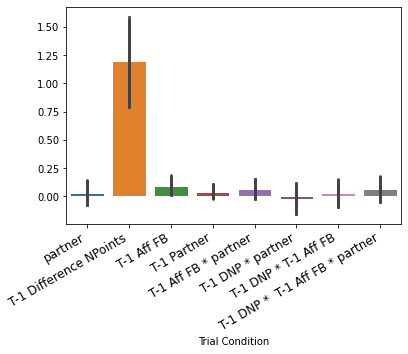

In [3]:
#get subject list 
subject_list = (pd.Series([(i.split('/'))[1] for i in file_list]).unique())

#make dataframe where subjects are rows and B0 per regressor are columns 
df = pd.DataFrame()
intercept = []

for i in subject_list: 
    x = list({i: get_model_weights(Subject(i).df)}.values())[0]
    df[i] = x
    
df = df.transpose()

#len(df.columns) == len(data.columns -1)
df.columns = ['partner',
              'T-1 Difference NPoints',
              'T-1 Aff FB',
              'T-1 Partner',
              'T-1 Aff FB * partner',
              'T-1 DNP * partner',
              'T-1 DNP * T-1 Aff FB',
              'T-1 DNP *  T-1 Aff FB * partner'
]

plotbot(df)

In [22]:
from hbayesdm import rhat, print_fit
from hbayesdm.models import bandit2arm_delta

all_df = []
for i in subject_list:
    
    df = Subject(i).df.loc[:, ['choice', 'aff_feedback_curr']]
    df['subjID'] = i
    df.rename(columns = {"aff_feedback_curr": "outcome"}, inplace=True)
    
    all_df.append(df)
    
df = pd.concat(all_df)

# Run the model and store results in "output"
output = bandit2arm_delta(data=df, niter=2000, nwarmup=1000, nchain=4, ncore=4)

# Visually check convergence of the sampling chains (should look like "hairy caterpillars")
output.plot(type='trace')

# Plot posterior distributions of the hyper-parameters (distributions should be unimodal)
output.plot()

# Check Rhat values (all Rhat values should be less than or equal to 1.1)
rhat(output, less=1.1)

# Show the LOOIC and WAIC model fit estimates
print_fit(output)

CRITICAL:pystan:Unable to read file specified by `file`.


FileNotFoundError: [Errno 2] No such file or directory: '/home/river/.local/lib/python3.8/site-packages/hbayesdm/common/stan_files/bandit2arm_delta.stan'

Rating task- 

'Indicate to what extent you feel this way right now:'

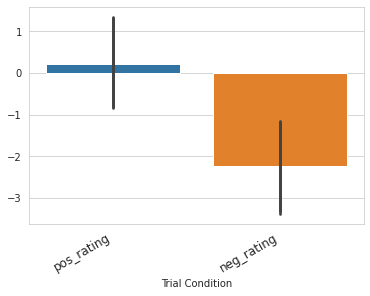

In [6]:
all_df = pd.DataFrame()

all_df = pd.DataFrame()

for i in subject_list:
    df = catch_ratings(Subject(i))
    
    pos_words = df[df['word_valence'] == 1].rating.mean()
    neg_words = df[df['word_valence'] == 0].rating.mean()
    
    #plot 1
    x = [pos_words, neg_words]
    
    all_df[i] = x


df = all_df.transpose()

df.columns = ['pos_rating',
              'neg_rating'
]

plotbot(df)

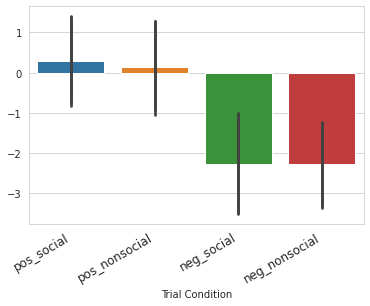

In [7]:
all_df = pd.DataFrame()

for i in subject_list:
    df = catch_ratings(Subject(i))
    
    pos_words = df[df['word_valence'] == 1]
    neg_words = df[df['word_valence'] == 0]
    
    #plot 2
    pos_social = pos_words[pos_words['partner'] == 1].rating.mean()
    pos_nonsocial = pos_words[pos_words['partner'] == 0].rating.mean()
    
    neg_social = neg_words[neg_words['partner'] == 1].rating.mean()
    neg_nonsocial = neg_words[neg_words['partner'] == 0].rating.mean()
    
    x = [pos_social, pos_nonsocial, neg_social, neg_nonsocial]
    
    all_df[i] = x


df = all_df.transpose()

df.columns = ['pos_social',
              'pos_nonsocial',
              'neg_social',
              'neg_nonsocial'
]

plotbot(df)

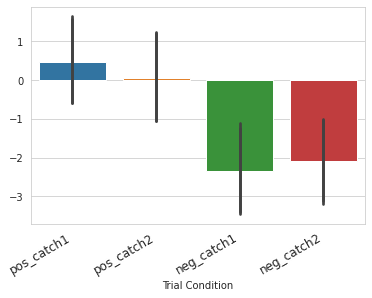

In [8]:
all_df = pd.DataFrame()

for i in subject_list:
    df = catch_ratings(Subject(i))
    pos_words = df[df['word_valence'] == 1]
    neg_words = df[df['word_valence'] == 0]
    
    #plot 2
    pos_catch1 = pos_words[pos_words['is_catch'] == 1].rating.mean()
    pos_catch2 = pos_words[pos_words['is_catch'] == 2].rating.mean()
    
    neg_catch1 = neg_words[neg_words['is_catch'] == 1].rating.mean()
    neg_catch2 = neg_words[neg_words['is_catch'] == 2].rating.mean()
    
    x = [pos_catch1, pos_catch2, neg_catch1, neg_catch2]
    
    all_df[i] = x
    
df = all_df.transpose()

df.columns = ['pos_catch1',
              'pos_catch2',
              'neg_catch1',
              'neg_catch2'
]

plotbot(df)

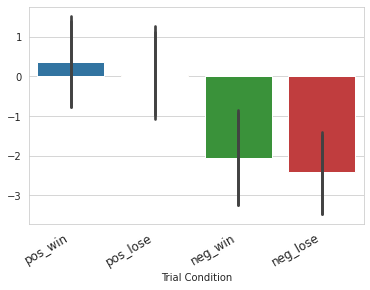

In [9]:
all_df = pd.DataFrame()

for i in subject_list:
    df = catch_ratings(Subject(i))
    
    pos_words = df[df['word_valence'] == 1]
    neg_words = df[df['word_valence'] == 0]
    
    pos_win = pos_words[pos_words['soc_win'] == 1].rating.mean()
    pos_lose = pos_words[pos_words['soc_win'] == 0].rating.mean()
    neg_win = neg_words[neg_words['soc_win'] == 1].rating.mean()
    neg_lose = neg_words[neg_words['soc_win'] == 0].rating.mean()
    
    x = [pos_win, pos_lose, neg_win, neg_lose]
    
    all_df[i] = x
    
df = all_df.transpose()

df.columns = ['pos_win',
              'pos_lose',
              'neg_win',
              'neg_lose'
]

plotbot(df)